In [129]:
# Import dependancies
import tweepy
import re
import requests
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import ast
import community
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from fa2 import ForceAtlas2
import networkx.algorithms.community as nx_comm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

The user_id column has to be read as a str:

In [31]:
# Load data
usernames_uk = pd.read_csv("data/uk/files/data_w_usernames_UK.csv",index_col=0, dtype={'user_id':str})

/Users/huayuan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [32]:
usernames_uk = usernames_uk.reset_index(drop = True)

In [33]:
mentions = pd.read_csv("data/uk/files/mentions_UK.csv", index_col = 0)
mentions = mentions.reset_index(drop=True)

Merging the dataframe that contains only the twitter with at least one mention with the dataframe that contained the scraped usernames

In [34]:
mentions['username'] = pd.merge(mentions, usernames_uk, on = "tweet_ID").iloc[:, -1] 

In [35]:
data_df = mentions

In [36]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1234294853330182144,20973388,covid,2020-03-02 01:49:59,0.406,0.613,0.458,0.271,0.460,-1.0,F,"The UK government is considering all options, ...",27.0,['darrenadam'],PatrickDoyle83
1,1234305116506861568,442831126,covid,2020-03-02 02:30:46,0.665,0.326,0.373,0.443,0.325,1.0,H,@Grummz An article for you after yesterday's m...,18.0,['Grummz'],BatemanStuart1
2,1234310189404348417,1157949934949347328,wuhan,2020-03-02 02:50:56,0.371,0.525,0.426,0.234,0.455,-1.0,F,@fascinatorfun So question is why the mortalit...,14.0,['fascinatorfun'],MUVAHOOD
3,1234318241431990272,16027848,covid,2020-03-02 03:22:55,0.329,0.587,0.570,0.138,0.474,-1.0,F,Video: #ToxicTories try to hide damage to NHS ...,27.0,['skwawkbox'],deadendfriends8
4,1234321940401270785,282914879,covid,2020-03-02 03:37:37,0.514,0.364,0.370,0.361,0.360,0.0,NaN,"@dray24574721 @BNODesk This, from S Korea afte...",15.0,"['dray24574721', 'BNODesk']",hoglet3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271091,1285835534766673923,916192094330507264,covid,2020-07-22 07:14:15,0.629,0.306,0.315,0.454,0.285,1.0,H,#Reboot weekends have started up again. #covi...,24.0,['actressann'],NaN
271092,1285835650059636736,3057049653,covid,2020-07-22 07:14:43,0.440,0.399,0.464,0.245,0.436,-1.0,A,@Gnomeponders My daughter and partner are both...,20.0,['Gnomeponders'],NaN
271093,1285835723740856321,216650916,covid,2020-07-22 07:15:00,0.598,0.336,0.330,0.406,0.318,1.0,H,Join on September 1st @ 5pm for a HealthChat w...,41.0,['RoyLilley'],NaN
271094,1285835987424337921,75508547,corona,2020-07-22 07:16:03,0.250,0.507,0.608,0.141,0.508,-2.0,A,@sidudeja But why would you want anyone dead? ...,24.0,['sidudeja'],NaN


Removing the rows for which it was not possible to retrieve the usernames:

In [37]:
data_df = data_df.dropna(subset=['username']).reset_index(drop=True)

In [38]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1234294853330182144,20973388,covid,2020-03-02 01:49:59,0.406,0.613,0.458,0.271,0.460,-1.0,F,"The UK government is considering all options, ...",27.0,['darrenadam'],PatrickDoyle83
1,1234305116506861568,442831126,covid,2020-03-02 02:30:46,0.665,0.326,0.373,0.443,0.325,1.0,H,@Grummz An article for you after yesterday's m...,18.0,['Grummz'],BatemanStuart1
2,1234310189404348417,1157949934949347328,wuhan,2020-03-02 02:50:56,0.371,0.525,0.426,0.234,0.455,-1.0,F,@fascinatorfun So question is why the mortalit...,14.0,['fascinatorfun'],MUVAHOOD
3,1234318241431990272,16027848,covid,2020-03-02 03:22:55,0.329,0.587,0.570,0.138,0.474,-1.0,F,Video: #ToxicTories try to hide damage to NHS ...,27.0,['skwawkbox'],deadendfriends8
4,1234321940401270785,282914879,covid,2020-03-02 03:37:37,0.514,0.364,0.370,0.361,0.360,0.0,NaN,"@dray24574721 @BNODesk This, from S Korea afte...",15.0,"['dray24574721', 'BNODesk']",hoglet3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269755,1285590859094863873,104942955,covid,2020-07-21 15:02:00,0.634,0.270,0.329,0.419,0.296,1.0,H,🌟 Free HR Advice 🌟\n\nInspiring People HR @Ins...,35.0,['InspiringPplHR'],opus_llp
269756,1285590913683722242,556875827,covid,2020-07-21 15:02:13,0.536,0.462,0.382,0.381,0.389,1.0,H,Excellent blog by @M_Winthrop - on the impacts...,32.0,['M_Winthrop'],bradleyyyshea
269757,1285591051756023809,102957958,covid,2020-07-21 15:02:46,0.578,0.405,0.402,0.348,0.389,1.0,H,#Wellbeing | Protecting #BAME employees from #...,36.0,['Generali_UK'],JarobeHHF
269758,1285591471194857474,1080551330849136641,covid,2020-07-21 15:04:26,0.399,0.414,0.458,0.275,0.485,-1.0,S,"@itslifeaslolly All but 3, due to complication...",43.0,['itslifeaslolly'],YLALawyers


To read each list in the column 'mentions' as a list and not as a str:

In [39]:
data_df['mentions'] = data_df['mentions'].apply(ast.literal_eval)

In [40]:
data_df_test = data_df.sample(frac=0.003)
data_df_test = data_df_test.reset_index(drop=True)

In [41]:
data_df_test.shape

(809, 15)

In [42]:
data_df_test.head(5)

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1260178426184507394,2974940176,covid,2020-05-12 12:02:04,0.590,0.329,0.393,0.419,0.362,1.0,H,As Boris ‘actively encourages’ a return to wor...,40.0,[ConstructionEnq],UKAvery
1,1239755908932153344,2195124065,covid,2020-03-17 03:30:16,0.447,0.502,0.412,0.298,0.426,-1.0,F,Test frontline NHS staff for COVID-19 as a pri...,17.0,[UKChange],buya789
2,1255857936716500992,64770437,covid,2020-04-30 13:53:59,0.560,0.381,0.369,0.353,0.358,1.0,H,The @TheSocialInvest and @BigSocietyCap have l...,38.0,"[TheSocialInvest, BigSocietyCap]",CIIGroup
3,1242513978070372353,14157231,wuhan,2020-03-24 18:09:51,0.598,0.320,0.376,0.468,0.374,1.0,H,What It Looks Like From Space When Everything ...,36.0,"[Planetlabs, business]",Tah72388211
4,1240394727452807168,1001067481795121152,covid,2020-03-18 21:48:43,0.320,0.544,0.595,0.197,0.541,-1.0,A,@CraigyJ86 Yep but they are wanting to delay p...,29.0,[CraigyJ86],jxssmitchell


In [43]:
data_df_test.tail(5)

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
804,1250779211016679425,474364743,covid,2020-04-16 13:32:56,0.472,0.444,0.366,0.186,0.405,-1.0,F,@mrjamesob this. #COVID-19 deaths https://t.co...,6.0,[mrjamesob],fdrcdocker
805,1249825413259501568,2848868002,covid,2020-04-13 22:22:53,0.428,0.437,0.517,0.252,0.429,-1.0,A,@Acosta Most triggered I’ve ever seen Trump - ...,41.0,[Acosta],iamsulemanraza
806,1262174146152325122,46771139,covid,2020-05-18 00:12:21,0.529,0.332,0.379,0.407,0.309,1.0,H,@DanielR48911902 @frojdepinnen @DBFetmann @Wen...,33.0,"[DanielR48911902, frojdepinnen, DBFetmann, Wen...",GRALCreates
807,1280078497902444544,146791075,covid,2020-07-06 09:57:51,0.402,0.481,0.492,0.258,0.436,-1.0,A,@mrdanwalker The woman is right in that wearin...,52.0,[mrdanwalker],SCA_jewellery
808,1246701604004417539,783215473857028096,covid,2020-04-05 07:29:59,0.428,0.444,0.498,0.276,0.404,-1.0,A,@DavidJoBrexit If @BorisJohnson is daft enough...,52.0,"[DavidJoBrexit, BorisJohnson]",sootgremlin_


# Network

In [44]:
dict_edges = dict(zip(data_df_test['username'], data_df_test['mentions']))

In [45]:
G = nx.DiGraph(dict_edges)

In [46]:
len(G.edges)

1412

In [47]:
len(G.nodes)

2052

In [48]:
in_degree_tuples = G.in_degree(G.nodes())
in_degree = [x[1] for x in in_degree_tuples] 

In [49]:
out_degree_tuples = G.out_degree(G.nodes())
out_degree = [x[1] for x in out_degree_tuples] 

In [51]:
print('In degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(in_degree),min(in_degree), np.median(in_degree)))
print('Out degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(out_degree),min(out_degree),np.median(out_degree)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_degree if i >5])))

In degree	max: 15	min: 0	median: 1.0
Out degree	max: 11	min: 0	median: 0.0
Nodes with in-degree larger than 100: 8


Comparison of in-degree and out-degree distributions. The in-degree distribution has been zoomed to make it clear that for most of the users the in-degree is similar to the out degree except for some outliers that have very large in-degree because probably they are famous accounts such as news account or popular people (politicians or influencers) or famous organizations. In-degree distribution plotted using a log scale for the y axis.

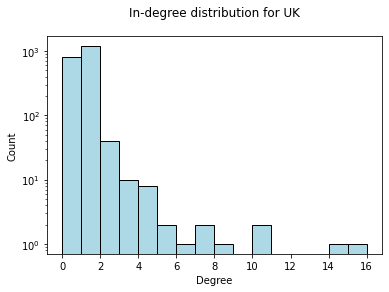

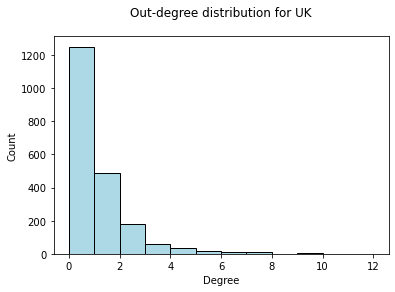

In [128]:
plt.title("In-degree distribution for UK",pad = 20.0)
plt.hist(in_degree, bins = np.arange(np.min(in_degree), np.max(in_degree)+2),color = 'lightblue',edgecolor = 'k')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.yscale('log')
plt.show()

plt.title("Out-degree distribution for UK",pad = 20.0)
plt.hist(out_degree, bins = np.arange(np.min(out_degree), np.max(out_degree)+2),color = 'lightblue',edgecolor = 'k')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()


In [54]:
dict_in_degree = dict(G.in_degree(G.nodes))
print("Top most in-degree connected users: ,", sorted(dict_in_degree, key=dict_in_degree.get, reverse=True)[:20])
dict_out_degree = dict(G.out_degree(G.nodes))
print("Top most out-degree connected users: ,", sorted(dict_out_degree, key=dict_out_degree.get, reverse=True)[:10])

Top most in-degree connected users: , ['BorisJohnson', 'UKChange', 'MattHancock', 'BBCNews', 'piersmorgan', 'YouTube', 'realDonaldTrump', 'SkyNews', 'MailOnline', 'afneil', 'carolecadwalla', 'Telegraph', 'ProfKarolSikora', 'WHO', 'Keir_Starmer', 'BBCPolitics', 'itvnews', 'Lord_Sugar', 'bmj_latest', 'Peston']
Top most out-degree connected users: , ['CJ_0206', 'WarberryLAP', 'RosannaMcGlone', 'wrexhamrob', 'CarshaltonHigh', 'mikeoutar', 'pam_das', 'BJHanssen', 'RhysBowker', 'heyseanpatrick']


**Visualization of Network**

100%|██████████| 2000/2000 [00:34<00:00, 57.60it/s]


BarnesHut Approximation  took  14.84  seconds
Repulsion forces  took  17.82  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.87  seconds


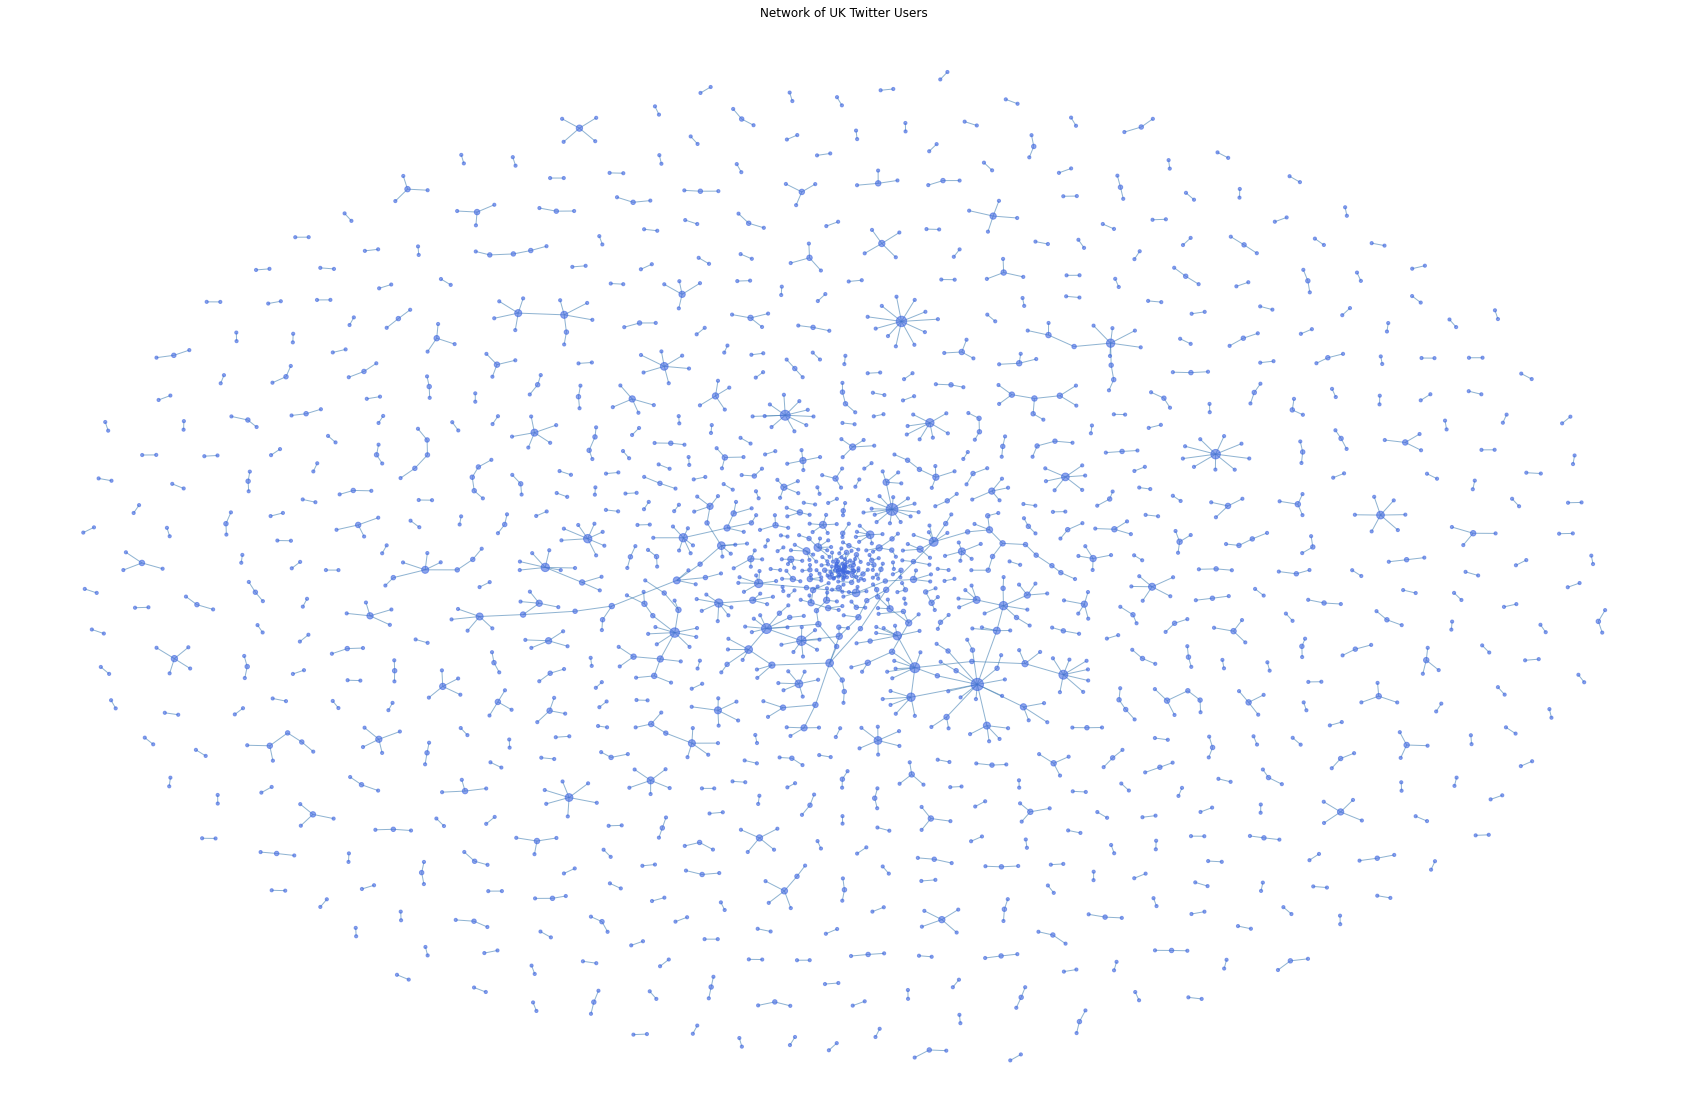

In [127]:
g = G.to_undirected()

# Get in-degrees in dict
degree_dict = dict(g.degree)

plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)

nx.draw_networkx(g, positions,nodelist=degree_dict.keys(), node_size=[v * 10 for v in degree_dict.values()], node_color = '#4169E1',alpha = 0.6, edge_color = 'steelblue',with_labels=False)

plt.axis('off')
plt.title('Network of UK Twitter Users')
plt.show()

# Tweets analysis

Remove links from tweet:

In [63]:
def find_https(tweet):
    tweet =re.sub('\.*amp\.*', '', tweet.lower())
    return re.sub("(http|https)://[\w\-]+(\.[\w\-]+)+\S*",'', tweet)

In [64]:
data_df = data_df_test
data_df['tweet'] = data_df['tweet'].apply(find_https)

In [66]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+') 

def tokenize_tweet(tweet):
    word_tokens = tokenizer.tokenize(tweet)
    filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words and not w.lower() in ['corona', 'wuhan', 'ncov', 'covid', 'covid_19', 'covid19', 'coronavirus']]
    return filtered_sentence

In [67]:
data_df['tokens'] = data_df['tweet'].apply(tokenize_tweet)

In [68]:
def remove_mentions(x, y):
    for el in y:
        try:
            x.remove(el.lower())
        except:
            pass

In [69]:
data_df.apply(lambda x: remove_mentions(x['tokens'], x['mentions']), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
804    None
805    None
806    None
807    None
808    None
Length: 809, dtype: object

# Identify communities

We use the unsupervised Louvain Algorithm for detecting communities:

In [70]:
partition = community.best_partition(g)

In [71]:
communities = np.unique(list(partition.values()))

The number of communities found is very large, however this was expected given the network also have numerous connections.

In [77]:
## Compute modularity for paritition ##

# Obtain representation of communities for nx_comm.modularity func
comms_dict = {}
for k, v in partition.items():
    str_v_ = str(v)
    if str_v_ not in comms_dict.keys():
        comms_dict[str_v_] = [k]
    else:
        comms_dict[str_v_].append(k)

comms_list = [v for k,v in comms_dict.items()]

M = nx_comm.modularity(g, comms_list)

print('Partition modularity : {}'.format(M))

Partition modularity : 0.9911006628734543


In [79]:
print("Number of found communities:")
print(max(communities))

comm_3_n = [i for i in comms_list if len(i) >=3]

print('Number of communities with more than 3 nodes: {}'.format(len(comm_3_n)))

Number of found communities:
646
Number of communities with more than 3 nodes: 253


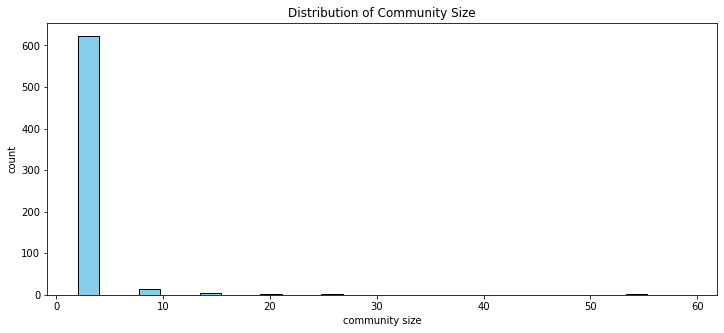

In [80]:
comms_sizes = [len(i) for i in comms_list]

plt.figure(figsize=(12,5))
plt.hist(comms_sizes,width=2,color='skyblue',edgecolor='k')
plt.xlabel('community size')
plt.ylabel('count')
plt.title('Distribution of Community Size')
plt.show()

In [81]:
d_input = dict(partition.items())
res = {}
for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

Extracting the 10 largest communities only:

In [83]:
count = 0
largest_communities = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:10]
texts = []

for i,t in enumerate(largest_communities):
    texts.append(np.concatenate(data_df.loc[data_df['username'].isin(t[1])]['tokens'].values))
    print(f"Community n. {i+1}. Size: {len(t[1])}")
    count += len(t[1])
    
print(f"\nAround {int(np.round(count/len(g.nodes), 2)*100)}% of network nodes is represented in these partitions.")

Community n. 1. Size: 59
Community n. 2. Size: 54
Community n. 3. Size: 30
Community n. 4. Size: 25
Community n. 5. Size: 23
Community n. 6. Size: 20
Community n. 7. Size: 18
Community n. 8. Size: 18
Community n. 9. Size: 14
Community n. 10. Size: 14

Around 13% of network nodes is represented in these partitions.


In [84]:
# to calculate the tf:
tf_texts = pd.Series(texts).apply(nltk.FreqDist)

In [85]:
doc_freq = nltk.FreqDist(np.concatenate(pd.Series(texts).apply(lambda x: list(set(x))).values))

In [86]:
idf_values = np.log10((1+21/(1+np.array(list(doc_freq.values()))))) + 1

In [87]:
idf = dict(zip(doc_freq.keys(), idf_values))

In [88]:
def calculate_tf_idf(tf, idf):
    return dict(zip(list(tf.keys()), np.array(list(tf.values()))*np.array([idf.get(w) for w in list(tf.keys())])))

In [89]:
tf_idf_series = pd.Series(tf_texts).apply(lambda x: calculate_tf_idf(x, idf))

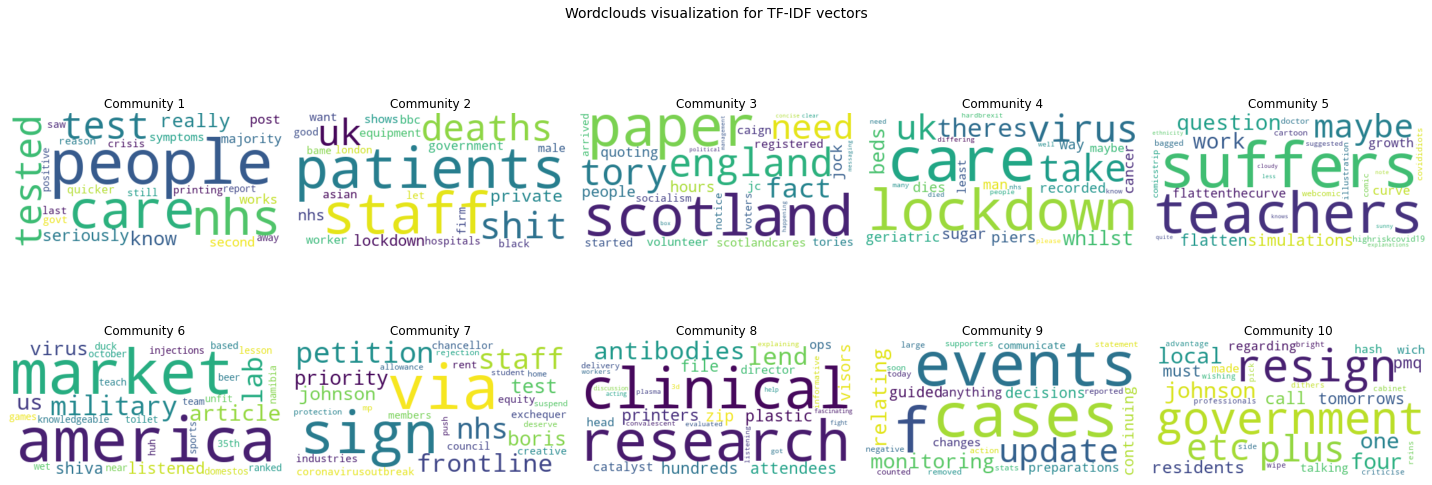

In [92]:
fig, ax = plt.subplots(2, 5, figsize= (20, 8))

c = 0
for i in range(2):
    for j in range(5):
        list_w = sorted(tf_idf_series[c], key=tf_idf_series[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(list_w))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c+1}")
        c += 1
fig.suptitle("Wordclouds visualization for TF-IDF vectors", fontsize = 14)
fig.tight_layout()
plt.show()

**Visualizing Community in Network**

In [94]:
# Reorganizing partition into dict structure
par_class = set(partition.values())
par_class_dict = {}

for v in partition.values():
    str_v = str(v)
    
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [96]:
# Getting top 10, again
par_class_dict = {k: v for k, v in sorted(par_class_dict.items(), key=lambda item: item[1],reverse = True)}
par_name_top10 = list(par_class_dict.keys())[:10]

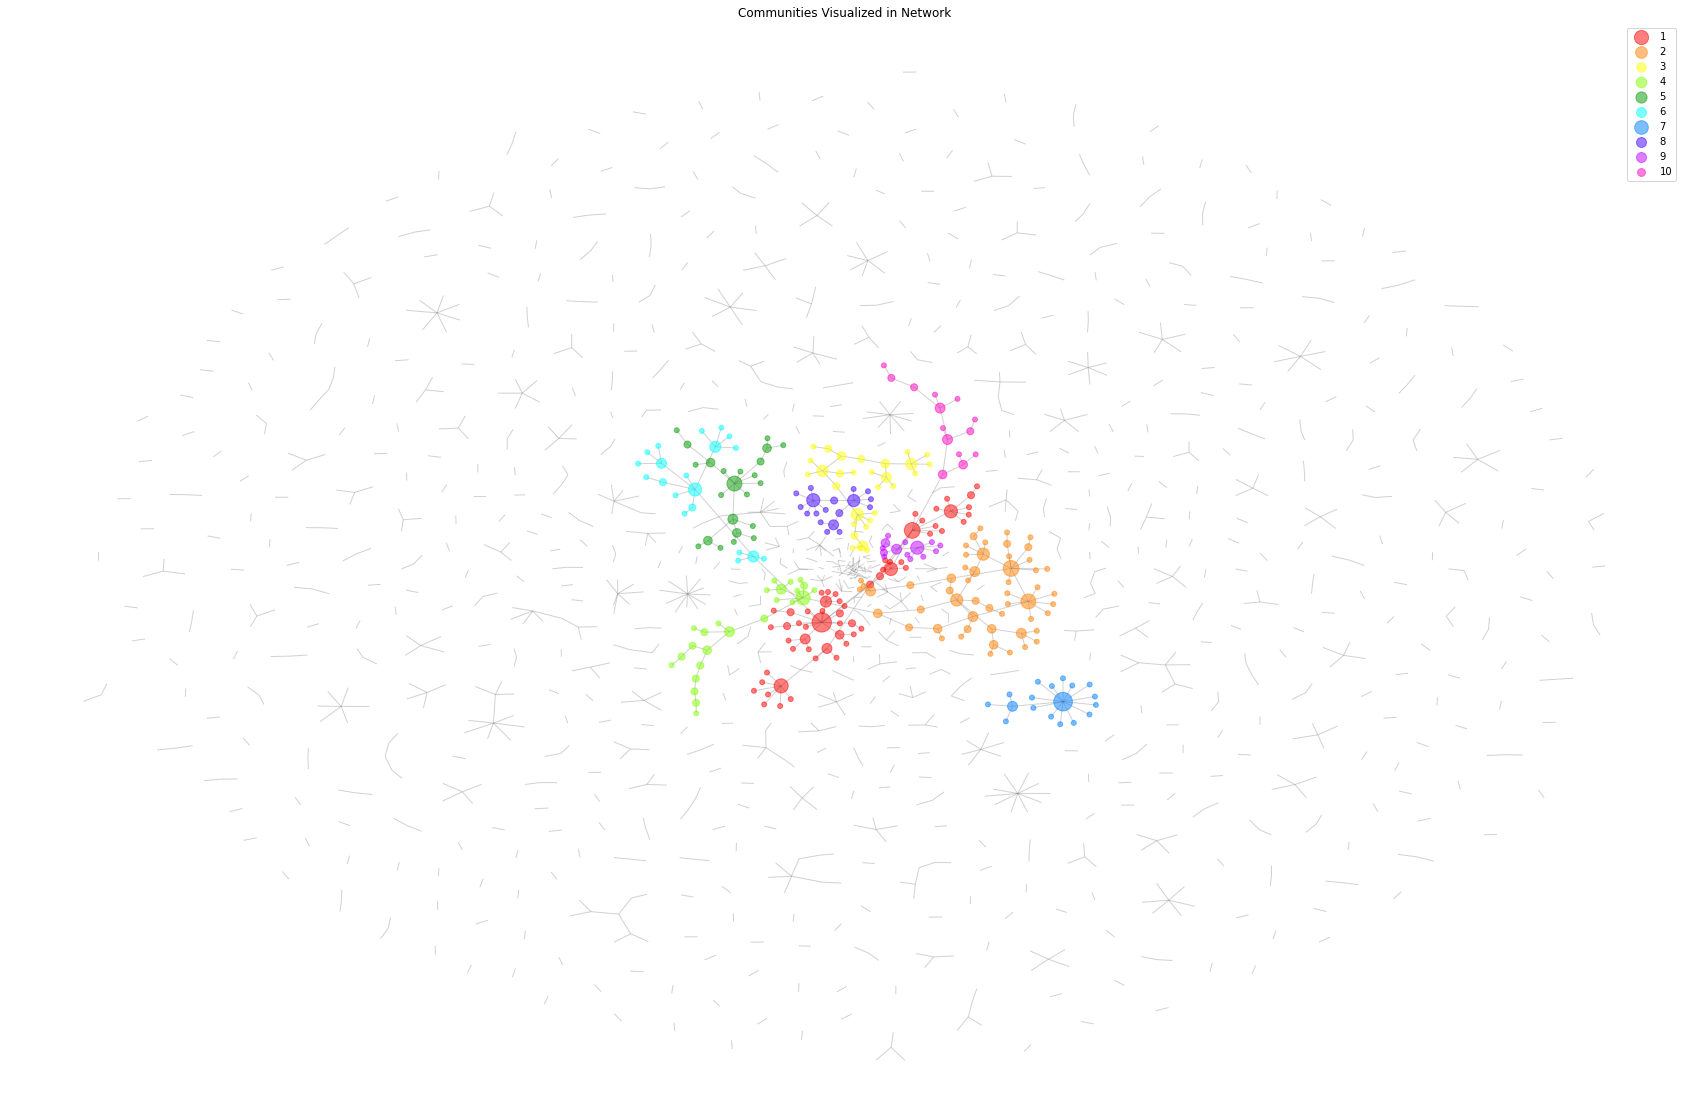

In [101]:
# Plot each community in network
plt.figure(figsize = (30,20))

nx.draw_networkx_edges(g,positions, alpha=0.3, edge_color = 'dimgray')

node_color_list = ['#ff0000','#ff8000','#ffff00','#80ff00',\
                   '#009900','#00ffff','#0080ff','#4000ff',\
                  '#bf00ff','#ff00bf']

for i,par_class in enumerate(par_name_top10):
    nodes = [n for n in list(g.nodes()) if partition[n] == int(par_class)]
    d = dict(g.degree(nodes))
    nx.draw_networkx_nodes(g, positions, d.keys(), node_size=[v*25 for v in d.values()],
                       node_color=node_color_list[i],alpha = 0.5,label =i+1)

plt.legend()   
plt.axis('off')
plt.title("Communities Visualized in Network")
plt.show()   

## Degree Centrality

To investigate degree centrality, we revert back to the directed version of the network graph.

In [103]:
# 5 most central characters according to degree centrality
in_degree_c = nx.in_degree_centrality(G)
out_degree_c = nx.out_degree_centrality(G)

# get the first 5 with in degree centrality
in_degree_c_sorted  = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (in degree centrality):\n{}'.format(in_degree_c_sorted[0:5]))
print('\n')

# get the first 5 with out degree centrality
out_degree_c_sorted  = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (out degree centrality):\n{}'.format(out_degree_c_sorted[0:5]))

5 most central users (in degree centrality):
[('BorisJohnson', 0.007313505607020965), ('UKChange', 0.006825938566552901), ('MattHancock', 0.0048756704046806435), ('BBCNews', 0.0048756704046806435), ('piersmorgan', 0.0039005363237445147)]


5 most central users (out degree centrality):
[('CJ_0206', 0.005363237445148708), ('WarberryLAP', 0.0048756704046806435), ('RosannaMcGlone', 0.004388103364212579), ('wrexhamrob', 0.004388103364212579), ('CarshaltonHigh', 0.004388103364212579)]


In [123]:
def plot_force_directed_graph(Graph, node_size_dict, fivemost_nodes, title_text, node_scale):
    """Make Force Atlas 2 directed graph plot of network with five most central nodes plotted.

        Args:
            Graph (NetworkX Graph object): NetworkX graph to plot.
            node_size_dict (dict): Dictionary of all nodes with value as node size and key for node name.
            fivemost_nodes (dict): Dictionary of five most central nodes with value as node size and key for node name.
            title_text (str): Title for plot.
            node_scale (int): Scaling factor for plotting the nodes.

    """
    
    plt.figure(figsize = (30,20))

    forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False,  # Dissuation
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0, # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(Graph, pos=None, iterations=2000)
    
    nx.draw_networkx(Graph, positions,nodelist=list(node_size_dict.keys()), node_size=[v * node_scale for v in node_size_dict.values()], alpha = 0.6,\
                        node_color = '#4169E1',edge_color = 'steelblue',with_labels=False)
    
    nx.draw_networkx_nodes(Graph, positions, nodelist=list(fivemost_nodes.keys()),node_size=[v * node_scale for v in fivemost_nodes.values()], \
                           alpha = 1, node_color="#4169E1",edgecolors ='black')
    labels = {}
    for node in fivemost_nodes.keys():
        labels[node] = node
    
    nx.draw_networkx_labels(Graph,positions,labels,font_size=18,font_color='k')
    
    plt.title(title_text,fontsize=28)
    plt.axis('off')
    plt.show()

100%|██████████| 2000/2000 [00:35<00:00, 55.88it/s]


BarnesHut Approximation  took  15.46  seconds
Repulsion forces  took  18.26  seconds
Gravitational forces  took  0.21  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.86  seconds


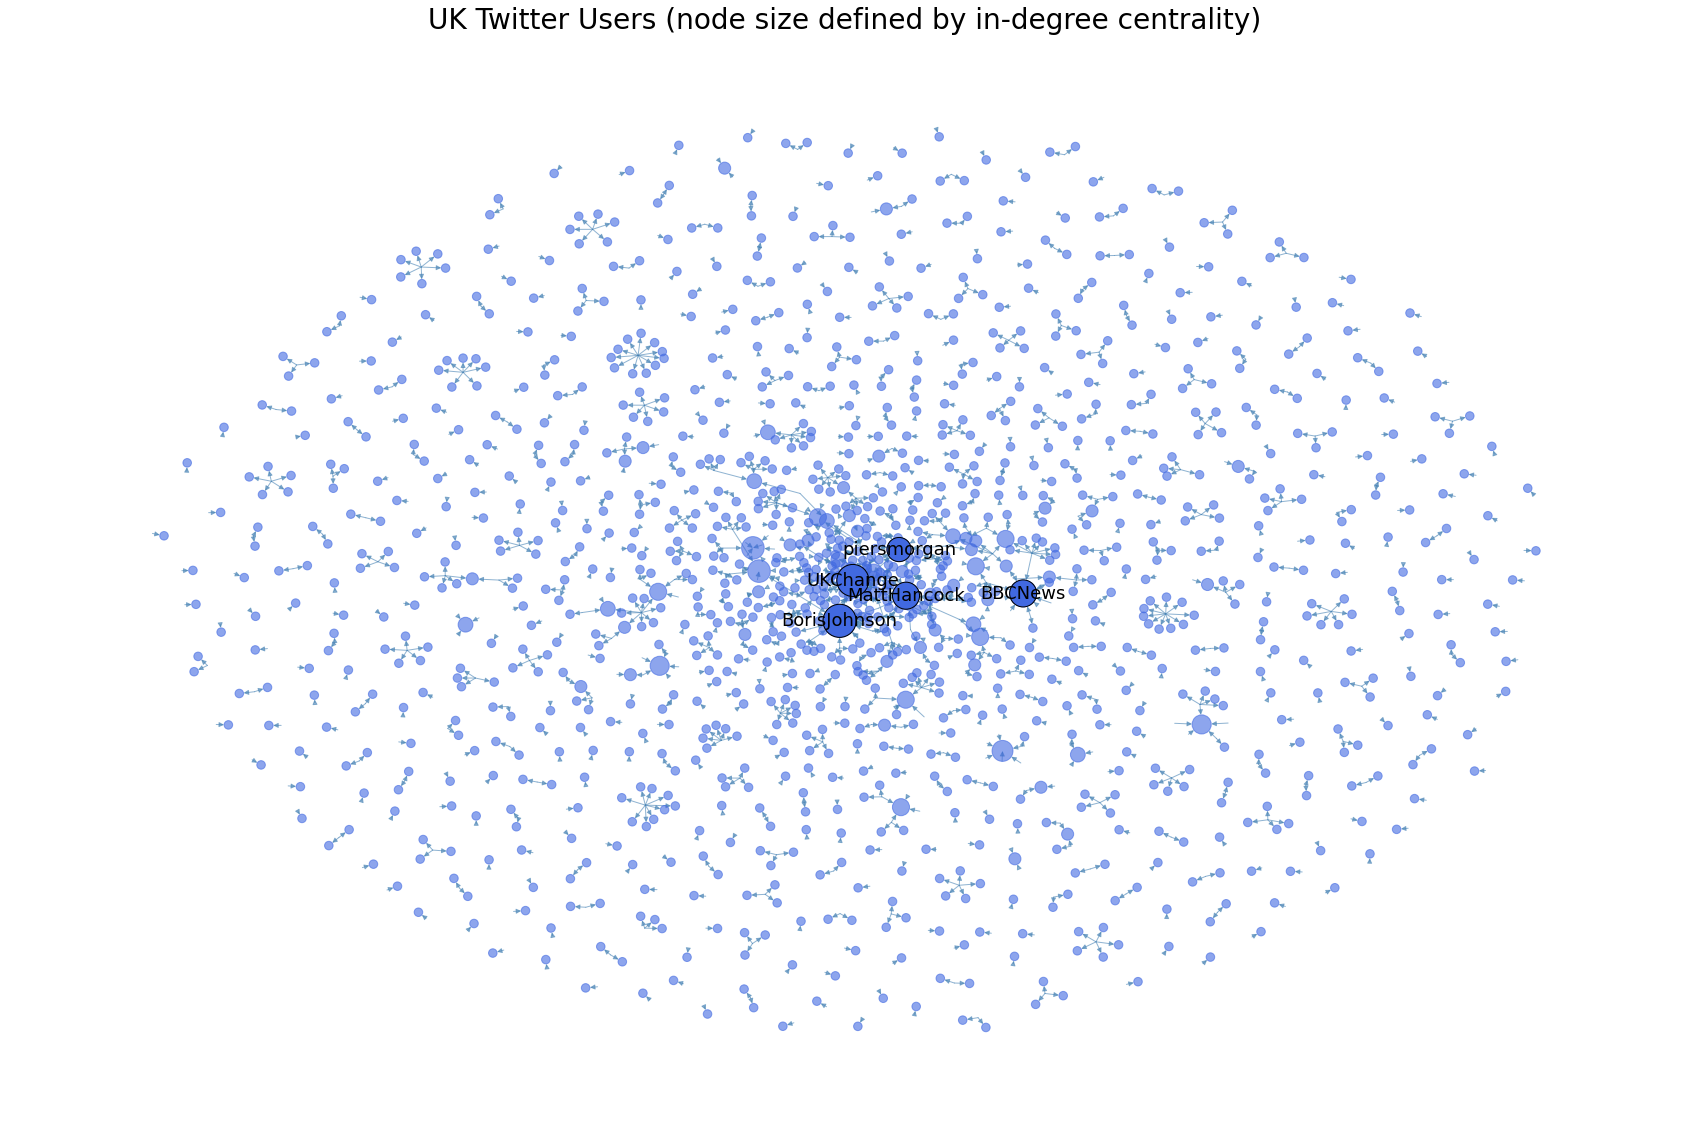

In [124]:
# Plot the network with in-degree centrality
in_degree_c_sorted = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
in_degree_c_sorted = dict(in_degree_c_sorted)
in_degree_c_sorted.update((x, y*10000) for x, y in in_degree_c_sorted.items())

# 5 most central users
nodes_ = list(in_degree_c_sorted)[0:5]
fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = in_degree_c_sorted[i]

title_text = 'UK Twitter Users (node size defined by in-degree centrality)'

plot_force_directed_graph(G, in_degree_c_sorted,fivemost_nodes,title_text, 15)

100%|██████████| 2000/2000 [00:34<00:00, 57.98it/s]


BarnesHut Approximation  took  14.68  seconds
Repulsion forces  took  17.79  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.85  seconds


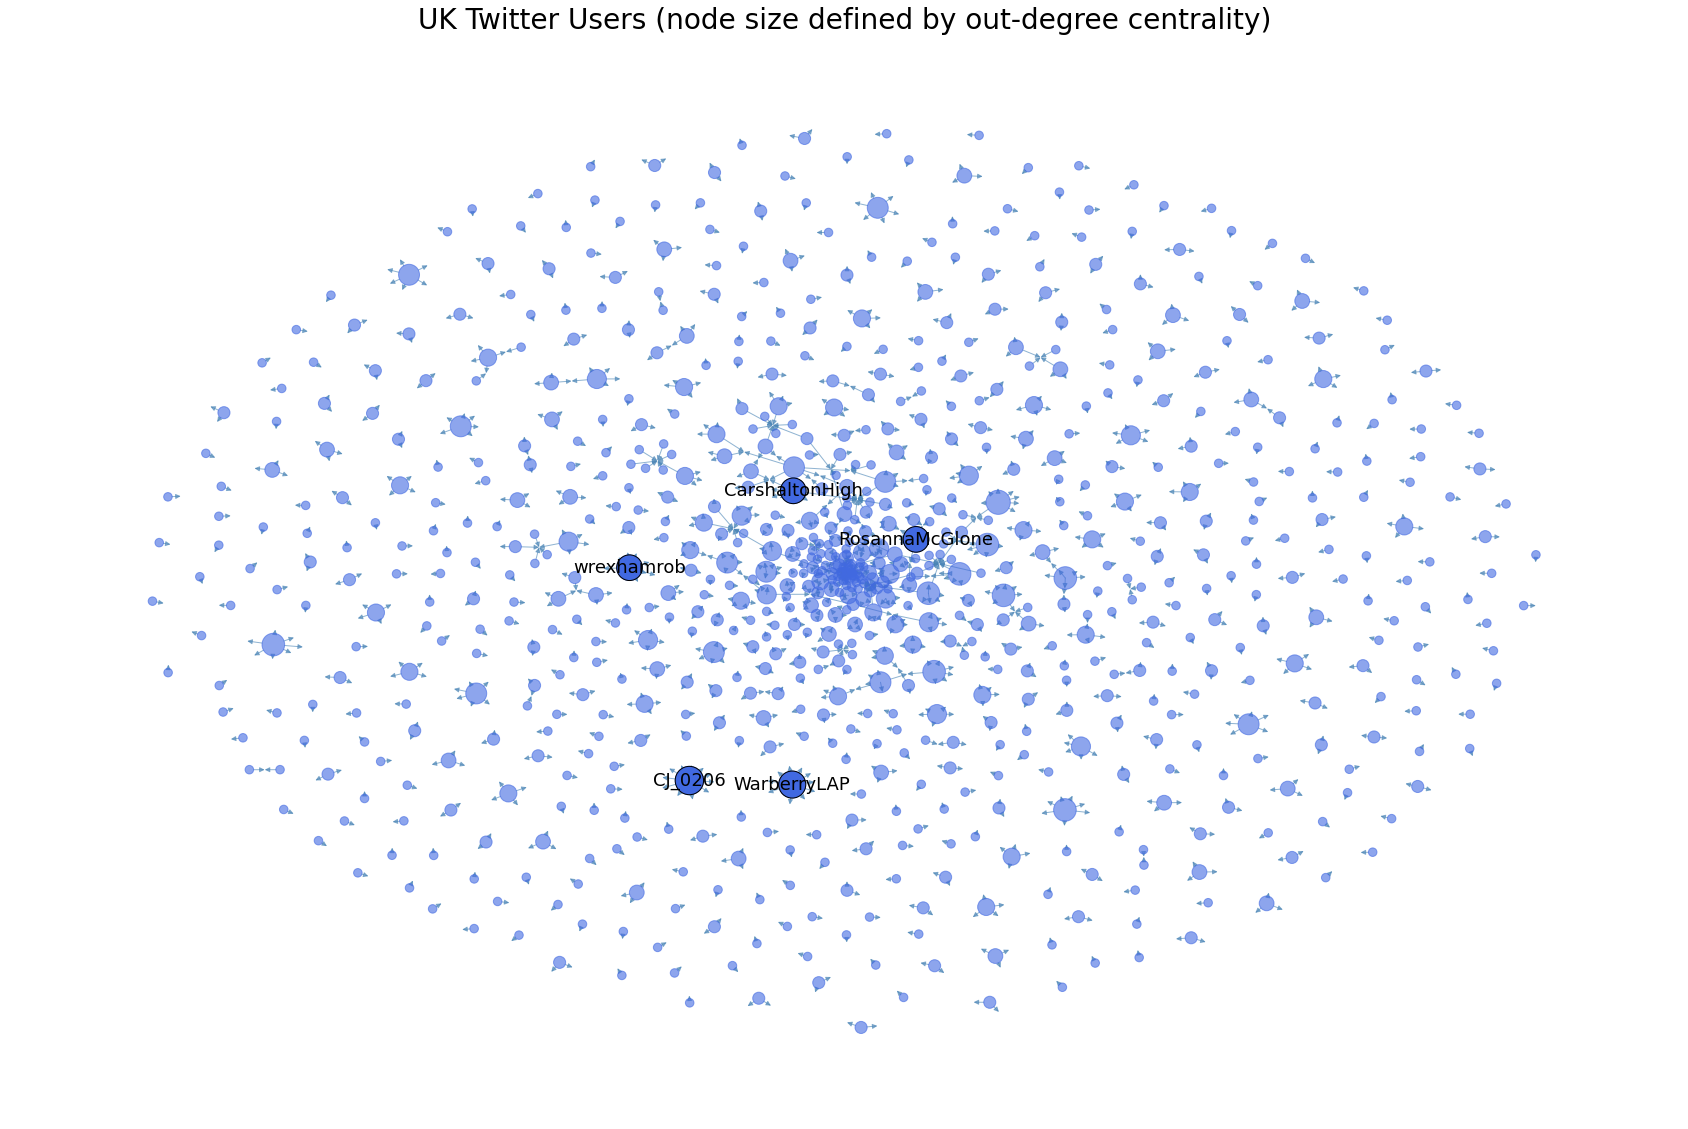

In [125]:
# Plot the network with out-degree centrality
out_degree_c_sorted = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
out_degree_c_sorted = dict(out_degree_c_sorted)
out_degree_c_sorted.update((x, y*10000) for x, y in out_degree_c_sorted.items())

# 5 most central users
nodes_ = list(out_degree_c_sorted)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = out_degree_c_sorted[i]

title_text = 'UK Twitter Users (node size defined by out-degree centrality)'

plot_force_directed_graph(G, out_degree_c_sorted,fivemost_nodes,title_text, 15)

**Betweenness Centrality for Undirected Graph**

In [113]:
between_c = nx.betweenness_centrality(g)

# the 5 most central characters according to betweenness centrality
bet_c_sorted  = sorted(between_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central characters (betweenness centrality):\n{}'.format(bet_c_sorted[0:5]))
print('\n')

5 most central characters (betweenness centrality):
[('BorisJohnson', 0.0013770795923463866), ('MattHancock', 0.0012491229739211092), ('TheAnuhart', 0.0007829613157174963), ('piersmorgan', 0.0007011451879511482), ('judgy100', 0.0006840208821395869)]




In [114]:
# Scale for better plotting
bet_c_sorted = dict(bet_c_sorted)
bet_c_sorted.update((x, y*100000) for x, y in between_c.items())

100%|██████████| 2000/2000 [00:34<00:00, 58.10it/s]


BarnesHut Approximation  took  14.74  seconds
Repulsion forces  took  17.64  seconds
Gravitational forces  took  0.21  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.86  seconds


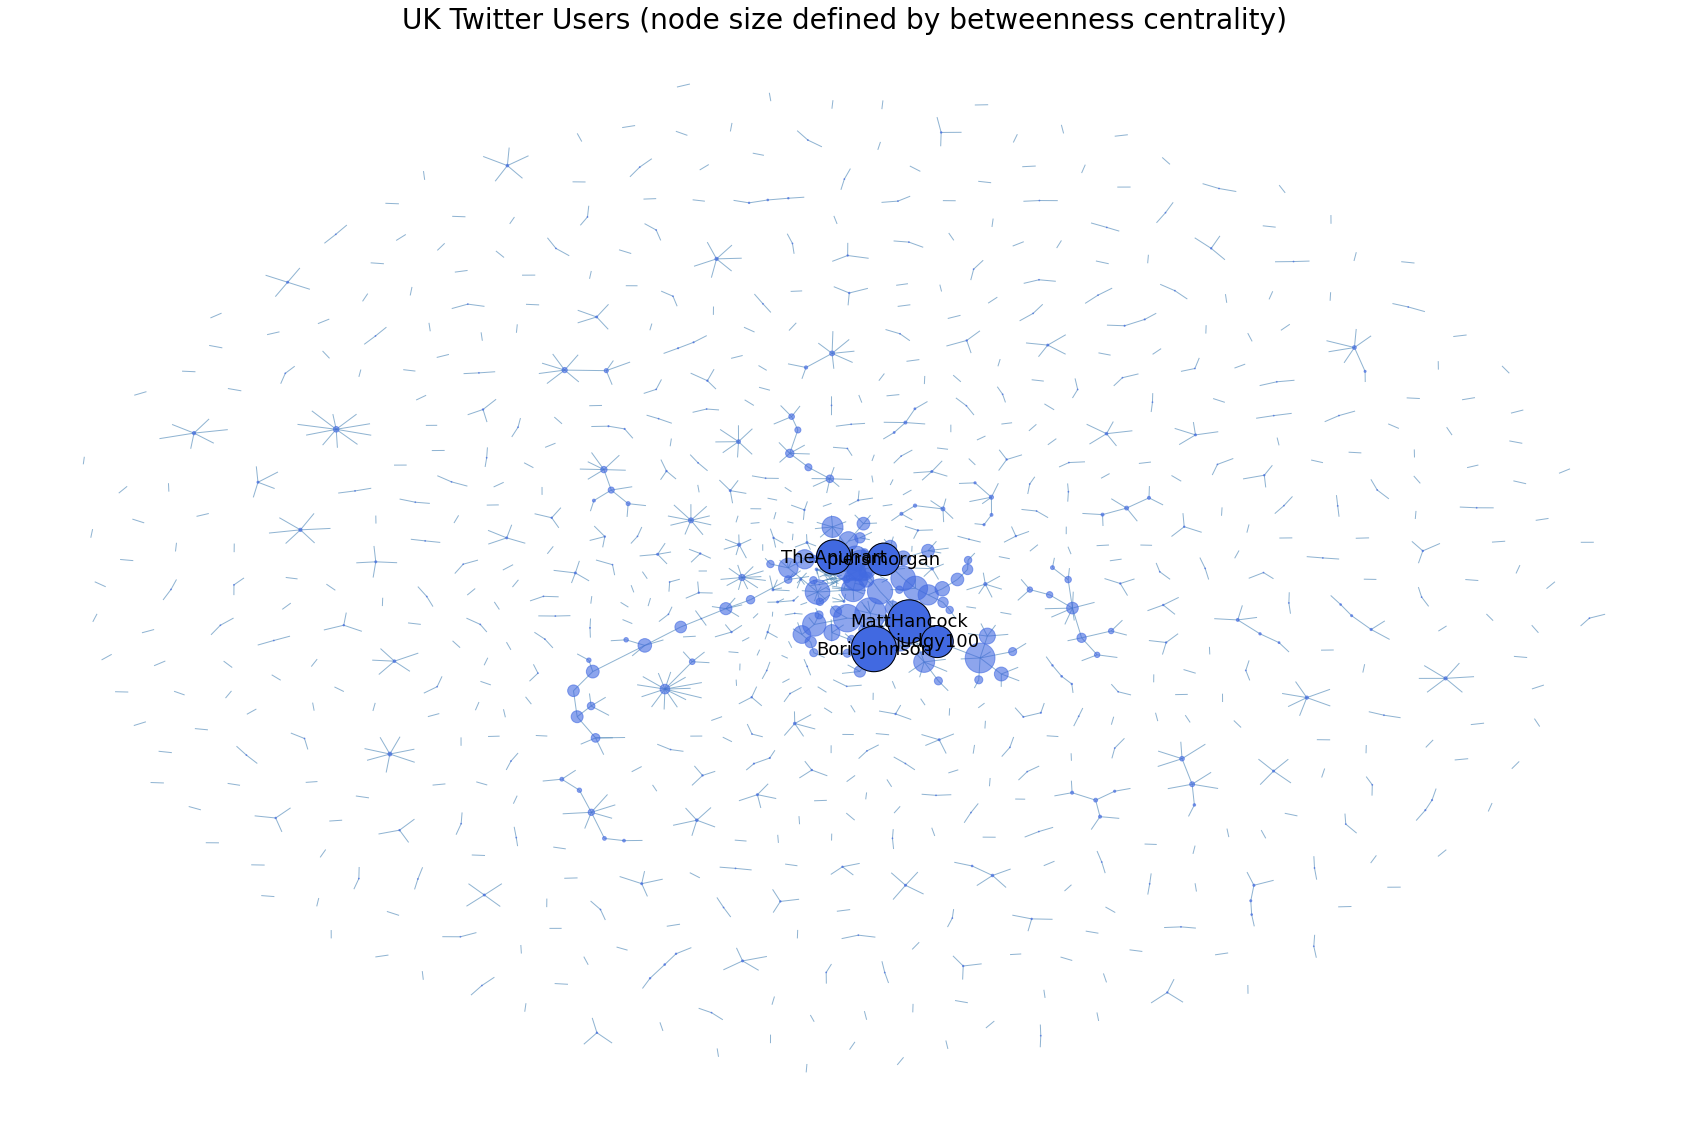

In [126]:
# 5 most central users
nodes_ = list(bet_c_sorted)[0:5]
fivemost_nodes = {}

for i in nodes_:
    fivemost_nodes[i] = bet_c_sorted[i]

plot_force_directed_graph(g, bet_c_sorted, fivemost_nodes,\
                          'UK Twitter Users (node size defined by betweenness centrality)', 15)

**How are nodes linked?**

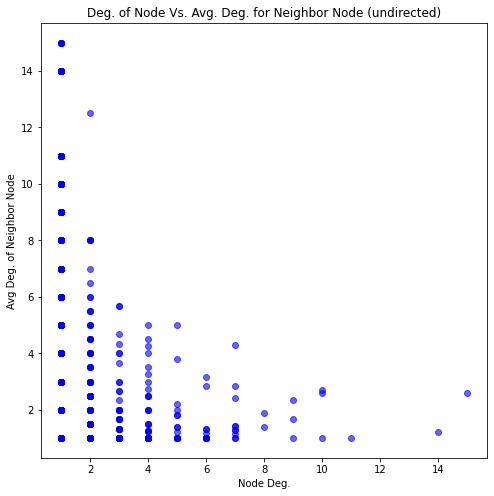

In [120]:
# undirected marvel network
avg_neigh_degrees = nx.average_neighbor_degree(g)

# plot
plt.figure(figsize=(8,8))
plt.scatter(dict(g.degree()).values(),avg_neigh_degrees.values(),c= 'blue',alpha=0.6)
plt.title('Deg. of Node Vs. Avg. Deg. for Neighbor Node (undirected)')
plt.xlabel('Node Deg.')
plt.ylabel('Avg Deg. of Neighbor Node')
plt.show()

**Check Peak/bottom Tweets**

In [146]:
# 
tweets_sents = pd.read_csv("data/uk/files/UK_sentiment.csv",index_col=0)
tweets_sents.head(5)

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,sentiment_score,week_number
Unnamed: 0,,,,,,,,,,,,,,,
1,1234290271774543872,2.488199e+08,covid,2020-03-02 01:31:47,0.380,0.611,0.412,0.218,0.460,-1.0,F,HEALTH EMERGENCY / INTERNATIONAL COVID-19 CORO...,8.0,4.890000,10
2,1234291397202776065,2.488199e+08,covid,2020-03-02 01:36:15,0.408,0.505,0.422,0.218,0.417,-1.0,F,HEALTH EMERGENCY / INTERNATIONAL COVID-19 CORO...,23.0,5.446000,10
3,1234292673260879872,4.476634e+08,corona,2020-03-02 01:41:20,0.448,0.566,0.419,0.267,0.415,-1.0,F,Corruption scaring corona virus from Africa &g...,7.0,4.392000,10
6,1234294853330182144,2.097339e+07,covid,2020-03-02 01:49:59,0.406,0.613,0.458,0.271,0.460,-1.0,F,"The UK government is considering all options, ...",27.0,5.437778,10
7,1234297018010333184,9.673640e+17,corona,2020-03-02 01:58:35,0.445,0.517,0.526,0.221,0.414,-1.0,A,USA the land of liberty charges $3000 to get t...,28.0,5.240952,10


In [155]:
tweets_sents_pos = tweets_sents.sort_values(by=['sentiment_score'], ascending=False)
tweets_sents_pos.head(5)

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,sentiment_score,week_number
Unnamed: 0,,,,,,,,,,,,,,,
317070,1252975500886257664,8.464426e+17,corona,2020-04-22 15:00:13,0.667,0.278,0.275,0.524,0.269,1.0,H,@RahulEaswar Both sunghis happy Corona,5.0,8.30,17
10241,1236291384660963328,7.023592e+17,corona,2020-03-07 14:03:29,0.548,0.295,0.288,0.349,0.394,1.0,H,@nitinrambler And corona laughs ...,5.0,8.18,10
283778,1250932213690105859,1.244997e+18,corona,2020-04-16 23:40:55,0.672,0.167,0.207,0.524,0.249,1.0,H,@leapsonline A pleasure,3.0,8.08,16
296238,1251614062292729858,1.244997e+18,corona,2020-04-18 20:50:20,0.670,0.179,0.219,0.467,0.200,1.0,H,@fjd_gough @EleanorSegall Our pleasure,4.0,8.08,16
250938,1248928423243890689,1.177232e+18,covid,2020-04-11 10:58:34,0.650,0.184,0.254,0.512,0.224,1.0,H,@CNash20 @agw1437 @MavisMoggie @acgrayling @CO...,7.0,8.08,15


In [157]:
tweets_sents_neg = tweets_sents.sort_values(by=['sentiment_score'])
tweets_sents_neg.head(5)

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,sentiment_score,week_number
Unnamed: 0,,,,,,,,,,,,,,,
563542,1269665912245882880,4.509041e+08,corona,2020-06-07 16:21:57,0.247,0.542,0.681,0.174,0.555,-2.0,A,@WestminsterWAG JUST WAIT N C HOW MANY WILL BE...,17.0,0.0,23
449942,1261542060202565633,1.953120e+08,covid,2020-05-16 06:20:40,0.451,0.380,0.464,0.365,0.369,-1.0,A,@asyagurji @RafaLop1 @morgan_covid A pstar Tro...,6.0,0.0,20
453595,1261787508364455937,1.297716e+08,covid,2020-05-16 22:35:59,0.383,0.521,0.555,0.239,0.544,-1.0,A,I. Need. A. New. Job. Where. I. Am. Treated. W...,32.0,0.0,20
449834,1261515051757961216,1.235785e+18,covid,2020-05-16 04:33:20,0.564,0.312,0.402,0.465,0.318,1.0,H,@StephenNolan I DO LISTEN TO STEPHEN NOLAN S...,33.0,0.0,20
453719,1261804061671776257,1.235785e+18,covid,2020-05-16 23:41:46,0.440,0.419,0.449,0.321,0.451,-1.0,S,@AndyGoulding IT THE NEW WAY FOR BBC LOC...,37.0,0.0,20


In [156]:
print("**Top 5 positive tweets**")

for i in range(0,5):
    print(" ")
    print("Tweet:")
    print(tweets_sents_pos["tweet"].iloc[i])

**Top 5 positive tweets**
 
Tweet:
@RahulEaswar Both sunghis happy Corona
 
Tweet:
@nitinrambler And corona laughs ...
 
Tweet:
@leapsonline A pleasure
 
Tweet:
@fjd_gough @EleanorSegall Our pleasure
 
Tweet:
@CNash20 @agw1437 @MavisMoggie @acgrayling @COVID_19Watch A pleasure.


In [158]:
print("**Top 5 negative tweets**")

for i in range(0,5):
    print(" ")
    print("Tweet:")
    print(tweets_sents_neg["tweet"].iloc[i])

**Top 5 negative tweets**
 
Tweet:
@WestminsterWAG JUST WAIT N C HOW MANY WILL BE DYING FROM CORONA BECAUSE OF THIS STUPID GATHERING
 
Tweet:
@asyagurji @RafaLop1 @morgan_covid A pstar Troll!!!
 
Tweet:
I. Need. A. New. Job. Where. I. Am. Treated. With. Fairness. And. Not. Felt. Belittled. And. On. Edge. And. My. Anxiety. Is. Not. Worsening. Due. To. Wanting. To. Be. Safe. From. Covid-19.
 
Tweet:
@StephenNolan I DO LISTEN  TO  STEPHEN NOLAN SHOW   ON BBC  RADIO FIVE  LIVE  AT WEEKENDS  WHEN  THEIR  IS   BIG  IMPORTANT  NEWS  LIKE  THIS  COVID  19    STEPHEN  NOLAN  IS  GOOD  AND  THAT  IS  TRUE
 
Tweet:
@AndyGoulding IT  THE  NEW  WAY  FOR  BBC  LOCAL  RADIO  BLOW  COVID  19  RUBBISH    AND  THE  NEWS  NOW  TIME  TO  PARTY  ONTO  4AM  AT  WEEKENDS  WITH  DANCE  AND  FUNK  AND  SOUL    AND  PARTY  MUSIC  AND  MIX  RECORDS    NOW
